# Epileptic seizure detection using recurrent neural networks

## In this jupyter notebook the preictal and interictal data is separated 
Juan David Torres Velasco
A01702686

In [1]:
#Import the necessary libraries
import os 
import numpy as np
import mne
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.pyplot as plot
import re
from random import randint

## Constants

In [2]:
SIXTYSECONDS = 60
SAMPLE_PER_SECOND = 256

MINUTES_PREICTAL = 16

# CHANNELS = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8']

CHANNELS = ["FP1-F7","F7-T7","T7-P7","P7-O1","FP1-F3","F3-C3","C3-P3","P3-O1","FP2-F4","F4-C4","C4-P4","P4-O2","FP2-F8","F8-T8","T8-P8-0","P8-O2","FZ-CZ","CZ-PZ"]
# CHANNELS = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
NUM_CHANNELS = len(CHANNELS)

REDUCED_PREICTAL_MINUTES = 1
TIMESTEP = 12
SECONDS_PER_TS = int(SIXTYSECONDS*REDUCED_PREICTAL_MINUTES/TIMESTEP)
SIZE_DATA = 2960
print("Length Channels", len(CHANNELS))

Length Channels 20


(20, 921600)
Creating RawArray with float64 data, n_channels=20, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


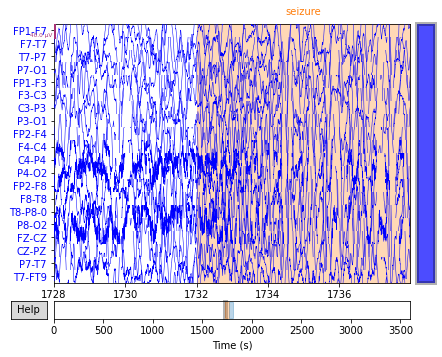

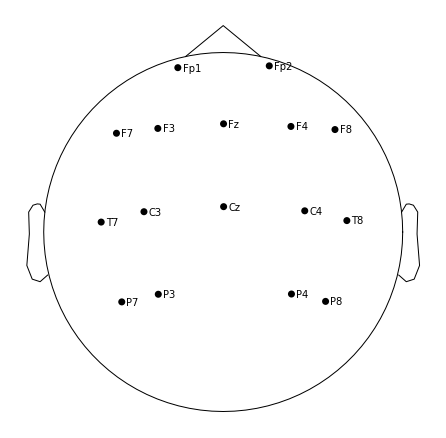

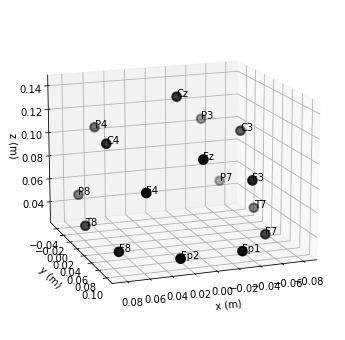

In [4]:
testpath = '/Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf'


raw = mne.io.read_raw_edf(testpath,verbose="ERROR")
d = raw.get_data(CHANNELS)
print(d.shape)
info = mne.create_info(ch_names=CHANNELS, sfreq=256, ch_types=['eeg']*d.shape[0] )

# create raw mne object
raw = mne.io.RawArray(d, info)
raw.set_annotations(mne.Annotations(onset=[1732,1772],duration=40,description=['seizure','']))
raw.plot(start=1728,color='b',)

replace_dict = {}
drop_list = []
# for the channel names in the data...
for channel_name in raw.info['ch_names']:
    # get the name to change too
    name_change = re.findall('\w+',channel_name)[0].title()
    # check if it is already in the change list
    if name_change in list(replace_dict.values()):
        drop_list.append(channel_name)
    else:
        # if its not already there get the origional name and what we want to 
        # change it to
        replace_dict[channel_name] = name_change

# drop the ones that would be repeats
raw.drop_channels(drop_list)
# rename the TESTchannels
raw.rename_channels(replace_dict)
# set the standard montage
raw.set_montage('standard_1020')

raw.plot_sensors(kind='topomap', show_names=True, to_sphere=True)
fig = raw.plot_sensors(kind='3d', show_names=True, show=False)
fig = fig.gca().view_init(azim=70, elev=15)
plot.show()

## Test the reading of the data

In [3]:
#this is the path where I stored the data for the CHB MIT dataset, replace accordingly, using EDF files
homepath = '/Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0'
path_test = homepath + '/chb01' 
raw = mne.io.read_raw_edf(path_test + '/chb01_03.edf')
raw2 = mne.io.read_raw_edf(path_test + '/chb01_02.edf')
d = raw.get_data(CHANNELS)
d2 = raw2.get_data(CHANNELS)
print(d.shape)
print(d2.shape)

temppp = np.concatenate((d,d2), axis = 1)

print(temppp.shape)


Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/2883669516.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path_test + '/chb01_03.edf')
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/2883669516.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw2 = mne.io.read_raw_edf(path_test + '/chb01_02.edf')


(20, 921600)
(20, 921600)
(20, 1843200)


## Initialize the structures that are going to be used

In [4]:

non_seizure_data = np.array([])
text_file = np.zeros(shape = (2,1))
total_arr_files_seizure = []

### Function to parse through the text file with the seizure information of the different .edf files

In [5]:
def parse_summary(text_file, home_path, minutes_preictal):
    file = open((home_path + '/' + text_file), 'r')
    Lines = file.readlines()
    seizures_count = 0
    i = 29
    array_seizure_start = []
    arrayEndTime = []
    seizure_list = []
    seizure_dict = {}
    total_records = 0
    file_names = []
    while i < len(Lines):
        print(i)
        file_name = Lines[i].split(": ",1)[1]
        file_name = file_name.replace(" ","")
        file_name = file_name.replace("\n","")
        file_names.append(file_name)

        number_seizures = int(Lines[i+3].split(": ",1)[1])

        array_seizure_start = []
        if number_seizures > 0:

            for j in range(number_seizures):
                print("Lines1",Lines[i+3+(j*2)+1].split(": ",1)[1])
                print("Lines2",Lines[i+3+(j*2)+2].split(": ",1)[1])
                start_of_seizure = Lines[i+3+(j*2)+2].split(": ",1)[1]
                start_of_seizure = start_of_seizure.replace(' seconds\n','')
                start_of_seizure = int(start_of_seizure)
                array_seizure_start.append(start_of_seizure)

            print("-",file_name,"-")
            raw = mne.io.read_raw_edf(home_path + '/' + file_name)
            print("CHANNELSS: ",CHANNELS)
            data = raw.get_data(CHANNELS)
            
            print("File name: ", file_name, " Shape ", data.shape)
            total_arr_files_seizure.append(file_name)

            for seizure_start in array_seizure_start:
                ictal_start = seizure_start * SAMPLE_PER_SECOND
                preictal_start = ictal_start - (SAMPLE_PER_SECOND * minutes_preictal * SIXTYSECONDS)
                # total_records += 
                print("Ictal start ",ictal_start,"Preictal start ",preictal_start, " Seconds:", seizure_start)
                if preictal_start >= 0:

                    if seizures_count == 0:
                        seizure_data_loc = data[:23,preictal_start:ictal_start]
                    else:
                        seizure_data_temp = np.concatenate((seizure_data_loc,data[:23,preictal_start:ictal_start]),axis=1)
                        seizure_data_loc = seizure_data_temp

                else:
                    
                    print("Preictal st",preictal_start)
                    raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
                    print("CHANNELSS: ",CHANNELS)
                    data_prev = raw_prev.get_data(CHANNELS)
                    print("SHAPEEEE ",len(data_prev[0]))
                    if seizures_count == 0:
                        
                        seizure_data_loc = data_prev[:23,(len(data_prev[0])+preictal_start):]
                        seizure_data_temp = np.concatenate((seizure_data_loc,data[:23,:ictal_start]),axis=1)
                        seizure_data_loc = seizure_data_temp
                        
                    else:

                        # if len(data_prev) < (-preictal_start):
                        #     print("------------------------------VERY SMALL DATA!!!!------------------------------")
                        #     break
                        seizure_data_temp = np.concatenate((seizure_data_loc,data_prev[:23,(len(data_prev[0])+preictal_start):]),axis=1)
                        seizure_data_loc = seizure_data_temp

                        seizure_data_temp = np.concatenate((seizure_data_loc,data[:23,:ictal_start]),axis=1)
                        seizure_data_loc = seizure_data_temp

                seizures_count += 1
            
            seizure_list.append({"file_name":file_name, "number_seizures":number_seizures})
            i += 2*number_seizures
            
        i += 5
    
    print(array_seizure_start)
    print(arrayEndTime)
    print("Seizure data shape",seizure_data_loc.shape)
    return seizure_data_loc





## Go through the different patients looking for the text file, parse throguh them and save the preictal data into a numpy darray

In [6]:
seizure_data = np.array([])
for i in range(1,25):
    if i <= 9:
            
            path = homepath + '/chb0' + str(i)
            
            files = os.listdir(path)
            for f in files:
                
                if  f.endswith('.txt'):
                    print("PATHH", path)
                    if i == 1:
                        seizure_data = parse_summary(f,path, MINUTES_PREICTAL)
                    else:
                        seizure_data_temporal = np.concatenate((seizure_data, parse_summary(f, path, MINUTES_PREICTAL)),axis=1)
                        seizure_data = seizure_data_temporal
                        
                    
                    print("Seizure data shape end",seizure_data.shape)
                    print(f)

        
        
    else:
        path = homepath + '/chb' + str(i)
        if  i!=24:
            # and i != 13 and i != 14
            files = os.listdir(path)
            for f in files:
                
                if f.endswith('.txt') :
                    print(f)
                    seizure_data_temporal = np.concatenate((seizure_data, parse_summary(f, path, MINUTES_PREICTAL)),axis=1)
                    seizure_data = seizure_data_temporal
                    print("Seizure data shape end",seizure_data.shape)
print(seizure_data.shape)  
print(total_arr_files_seizure)
np.save('/Volumes/Seagate Hard Drive/Tesina/preictal2', seizure_data, allow_pickle=True, fix_imports=False)

PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
29
34
39
Lines1 2996 seconds

Lines2 3036 seconds

- chb01_03.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
File name:  chb01_03.edf  Shape  (20, 921600)
Ictal start  777216 Preictal start  470016  Seconds: 3036
46
Lines1 1467 seconds

Lines2 1494 seconds

- chb01_04.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 

/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb01_04.edf  Shape  (20, 921600)
Ictal start  382464 Preictal start  75264  Seconds: 1494
53
58
63
68
73
78
83
88
93
98
103
Lines1 1732 seconds

Lines2 1772 seconds

- chb01_15.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb01_15.edf  Shape  (20, 921600)
Ictal start  453632 Preictal start  146432  Seconds: 1772
110
Lines1 1015 seconds

Lines2 1066 seconds

- chb01_16.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb01_16.edf  Shape  (20, 921600)
Ictal start  272896 Preictal start  -34304  Seconds: 1066
Preictal st -34304
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


117
122
Lines1 1720 seconds

Lines2 1810 seconds

- chb01_18.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb01_18.edf  Shape  (20, 921600)
Ictal start  463360 Preictal start  156160  Seconds: 1810
129
134
139
Lines1 327 seconds

Lines2 420 seconds

- chb01_21.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb01_21.edf  Shape  (20, 921600)
Ictal start  107520 Preictal start  -199680  Seconds: 420
Preictal st -199680
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


146
151
156
161
166
Lines1 1862 seconds

Lines2 1963 seconds

- chb01_26.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb01_26.edf  Shape  (20, 595200)
Ictal start  502528 Preictal start  195328  Seconds: 1963
173
178
183
188
193
198
203
208
213
218
223
228
233
238
243
248
[]
[]
Seizure data shape (20, 2150400)
Seizure data shape end (20, 2150400)
chb01-summary.txt
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
Lines1 130 seconds

Lines2 212 seconds

- chb02_16.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
File name:  chb02_16.edf  Shape  (20, 245504)
Ictal start  54272 Preictal start  -252928  Seconds: 212
Preictal st -252928
Extracting EDF parameters

/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb02_16+.edf  Shape  (20, 921600)
Ictal start  781568 Preictal start  474368  Seconds: 3053
118
123
128
Lines1 3369 seconds

Lines2 3378 seconds

- chb02_19.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb02_19.edf  Shape  (20, 921600)
Ictal start  864768 Preictal start  557568  Seconds: 3378
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
[]
[]
Seizure data shape (20, 676096)
Seizure data shape end (20, 2826496)
chb02-summary.txt
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
29
Lines1 362 seconds

Lines2 414 seconds

- chb03_01.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb03_01.edf  Shape  (20, 921600)
Ictal start  105984 Preictal start  -201216  Seconds: 414
Preictal st -201216
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600
36
Lines1 731 seconds

Lines2 796 seconds

- chb03_02.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', '

/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb03_02.edf  Shape  (20, 921600)
Ictal start  203776 Preictal start  -103424  Seconds: 796
Preictal st -103424
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600
43
Lines1 432 seconds

Lines2 501 seconds

- chb03_03.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', '

/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb03_03.edf  Shape  (20, 921600)
Ictal start  128256 Preictal start  -178944  Seconds: 501
Preictal st -178944
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600
50
Lines1 2162 seconds

Lines2 2214 seconds

- chb03_04.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
File name:  chb03_04.edf  Shape  (20, 921600)
Ictal start  566784 Preictal start  259584  Seconds: 2214
57
62
67
72
77
82
87
92
97
102
107
112
117
122
127
132
137
142
147
152
157
162
167
172
177
182
187
192
197
202
Lines1 1982 seconds

Lines2 2029 seconds

- chb03_34.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb03_34.edf  Shape  (20, 921600)
Ictal start  519424 Preictal start  212224  Seconds: 2029
209
Lines1 2592 seconds

Lines2 2656 seconds

- chb03_35.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb03_35.edf  Shape  (20, 921600)
Ictal start  679936 Preictal start  372736  Seconds: 2656
216
Lines1 1725 seconds

Lines2 1778 seconds

- chb03_36.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb03_36.edf  Shape  (20, 921600)
Ictal start  455168 Preictal start  147968  Seconds: 1778
223
228
[]
[]
Seizure data shape (20, 2150400)
Seizure data shape end (20, 4976896)
chb03-summary.txt
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
29
34
39
44
49
Lines1 7804 seconds

Lines2 7853 seconds

- chb04_05.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb04_05.edf  Shape  (20, 2441216)
Ictal start  2010368 Preictal start  1703168  Seconds: 7853
56
61
66
Lines1 6446 seconds

Lines2 6557 seconds

- chb04_08.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb04_08.edf  Shape  (20, 3686400)
Ictal start  1678592 Preictal start  1371392  Seconds: 6557
73
78
83
88
93
98
103
108
113
118
123
128
133
138
143
148
153
158
163
Lines1 1679 seconds

Lines2 1781 seconds

Lines1 3782 seconds

Lines2 3898 seconds

- chb04_28.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb04_28.edf  Shape  (20, 3692288)
Ictal start  455936 Preictal start  148736  Seconds: 1781
Ictal start  997888 Preictal start  690688  Seconds: 3898
172
177
182
187
192
197
202
207
212
217
222
227
232
237
242
[]
[]
Seizure data shape (20, 1228800)
Seizure data shape end (20, 6205696)
chb04-summary.txt
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
29
34
39
44
49
54
Lines1 417 seconds

Lines2 532 seconds

- chb05_06.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb05_06.edf  Shape  (20, 921600)
Ictal start  136192 Preictal start  -171008  Seconds: 532
Preictal st -171008
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600
61
66
71
76
81
86
91
Lines1 1086 seconds

Lines2 1196 seconds

- chb05_13.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ',

/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb05_13.edf  Shape  (20, 921600)
Ictal start  306176 Preictal start  -1024  Seconds: 1196
Preictal st -1024
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600
98
103
108
Lines1 2317 seconds

Lines2 2413 seconds

- chb05_16.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7

/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb05_16.edf  Shape  (20, 921600)
Ictal start  617728 Preictal start  310528  Seconds: 2413
115
Lines1 2451 seconds

Lines2 2571 seconds

- chb05_17.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb05_17.edf  Shape  (20, 921600)
Ictal start  658176 Preictal start  350976  Seconds: 2571
122
127
132
137
142
Lines1 2348 seconds

Lines2 2465 seconds

- chb05_22.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb05_22.edf  Shape  (20, 921600)
Ictal start  631040 Preictal start  323840  Seconds: 2465
149
154
159
164
169
174
179
184
189
194
199
204
209
214
219
224
229
[]
[]
Seizure data shape (20, 1536000)
Seizure data shape end (20, 7741696)
chb05-summary.txt
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06
29
Lines1 1724 seconds

Lines2 1738 seconds

Lines1 7461 seconds

Lines2 7476 seconds

Lines1 13525 seconds

Lines2 13540 seconds

- chb06_01.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb06_01.edf  Shape  (20, 3693312)
Ictal start  444928 Preictal start  137728  Seconds: 1738
Ictal start  1913856 Preictal start  1606656  Seconds: 7476
Ictal start  3466240 Preictal start  3159040  Seconds: 13540
40
45
50
Lines1 327 seconds

Lines2 347 seconds

Lines1 6211 seconds

Lines2 6231 seconds

- chb06_04.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb06_04.edf  Shape  (20, 3394816)
Ictal start  88832 Preictal start  -218368  Seconds: 347
Preictal st -218368
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


SHAPEEEE  3394816
Ictal start  1595136 Preictal start  1287936  Seconds: 6231
59
64
69
74
79
Lines1 12500 seconds

Lines2 12516 seconds

- chb06_09.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb06_09.edf  Shape  (20, 3686400)
Ictal start  3204096 Preictal start  2896896  Seconds: 12516
86
Lines1 10833 seconds

Lines2 10845 seconds

- chb06_10.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb06_10.edf  Shape  (20, 3686400)
Ictal start  2776320 Preictal start  2469120  Seconds: 10845
93
98
Lines1 506 seconds

Lines2 519 seconds

- chb06_13.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb06_13.edf  Shape  (20, 3686400)
Ictal start  132864 Preictal start  -174336  Seconds: 519
Preictal st -174336
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


SHAPEEEE  3686400
105
110
115
120
125
Lines1 7799 seconds

Lines2 7811 seconds

- chb06_18.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb06_18.edf  Shape  (20, 2029568)
Ictal start  1999616 Preictal start  1692416  Seconds: 7811
132
Lines1 9387 seconds

Lines2 9403 seconds

- chb06_24.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb06/chb06_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb06_24.edf  Shape  (20, 3686400)
Ictal start  2407168 Preictal start  2099968  Seconds: 9403
[9403]
[]
Seizure data shape (20, 3072000)
Seizure data shape end (20, 10813696)
chb06-summary.txt
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb07
29
34
39
44
49
54
59
64
69
74
79
84
Lines1 4920 seconds

Lines2 5006 seconds

- chb07_12.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb07_12.edf  Shape  (20, 3686400)
Ictal start  1281536 Preictal start  974336  Seconds: 5006
91
Lines1 3285 seconds

Lines2 3381 seconds

- chb07_13.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb07_13.edf  Shape  (20, 953856)
Ictal start  865536 Preictal start  558336  Seconds: 3381
98
103
108
113
118
123
Lines1 13688 seconds

Lines2 13831 seconds

- chb07_19.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb07/chb07_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb07_19.edf  Shape  (20, 3689216)
Ictal start  3540736 Preictal start  3233536  Seconds: 13831
[13831]
[]
Seizure data shape (20, 921600)
Seizure data shape end (20, 11735296)
chb07-summary.txt
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb08
29
Lines1 2670 seconds

Lines2 2841 seconds

- chb08_02.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb08_02.edf  Shape  (20, 921600)
Ictal start  727296 Preictal start  420096  Seconds: 2841
36
41
46
Lines1 2856 seconds

Lines2 3046 seconds

- chb08_05.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb08_05.edf  Shape  (20, 921600)
Ictal start  779776 Preictal start  472576  Seconds: 3046
53
58
Lines1 2988 seconds

Lines2 3122 seconds

- chb08_11.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb08_11.edf  Shape  (20, 921600)
Ictal start  799232 Preictal start  492032  Seconds: 3122
65
70
Lines1 2417 seconds

Lines2 2577 seconds

- chb08_13.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb08_13.edf  Shape  (20, 921600)
Ictal start  659712 Preictal start  352512  Seconds: 2577
77
82
87
92
97
102
107
112
Lines1 2083 seconds

Lines2 2347 seconds

- chb08_21.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb08/chb08_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb08_21.edf  Shape  (20, 921600)
Ictal start  600832 Preictal start  293632  Seconds: 2347
119
124
129
134
[]
[]
Seizure data shape (20, 1536000)
Seizure data shape end (20, 13271296)
chb08-summary.txt
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb09
29
34
39
44
49
54
Lines1 12231 seconds

Lines2 12295 seconds

- chb09_06.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb09_06.edf  Shape  (20, 3686144)
Ictal start  3147520 Preictal start  2840320  Seconds: 12295
61
66
Lines1 2951 seconds

Lines2 3030 seconds

Lines1 9196 seconds

Lines2 9267 seconds

- chb09_08.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb09_08.edf  Shape  (20, 3686400)
Ictal start  775680 Preictal start  468480  Seconds: 3030
Ictal start  2372352 Preictal start  2065152  Seconds: 9267
75
80
85
90
95
100
105
110
115
120
125
Lines1 5299 seconds

Lines2 5361 seconds

- chb09_19.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb09/chb09_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb09_19.edf  Shape  (20, 1459200)
Ictal start  1372416 Preictal start  1065216  Seconds: 5361
[5361]
[]
Seizure data shape (20, 1228800)
Seizure data shape end (20, 14500096)
chb09-summary.txt
chb10-summary.txt
29
34
39
44
49
54
59
64
69
Lines1 6313 seconds

Lines2 6348 seconds

- chb10_12.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb10_12.edf  Shape  (20, 1843200)
Ictal start  1625088 Preictal start  1317888  Seconds: 6348
76
81
86
91
96
101
106
111
Lines1 6888 seconds

Lines2 6958 seconds

- chb10_20.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb10_20.edf  Shape  (20, 1846272)
Ictal start  1781248 Preictal start  1474048  Seconds: 6958
118
123
128
Lines1 2382 seconds

Lines2 2447 seconds

- chb10_27.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb10_27.edf  Shape  (20, 1847808)
Ictal start  626432 Preictal start  319232  Seconds: 2447
135
140
Lines1 3021 seconds

Lines2 3079 seconds

- chb10_30.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb10_30.edf  Shape  (20, 1846528)
Ictal start  788224 Preictal start  481024  Seconds: 3079
147
Lines1 3801 seconds

Lines2 3877 seconds

- chb10_31.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb10_31.edf  Shape  (20, 1848576)
Ictal start  992512 Preictal start  685312  Seconds: 3877
154
Lines1 4618 seconds

Lines2 4707 seconds

- chb10_38.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb10_38.edf  Shape  (20, 1843200)
Ictal start  1204992 Preictal start  897792  Seconds: 4707
161
Lines1 1383 seconds

Lines2 1437 seconds

- chb10_89.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_89.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb10_89.edf  Shape  (20, 1843200)
Ictal start  367872 Preictal start  60672  Seconds: 1437
[1437]
[]
Seizure data shape (20, 2150400)
Seizure data shape end (20, 16650496)
chb11-summary.txt
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
114
119
124
129
134
139
144
149
154
159
164
169
174
179
184
189
Lines1 298 seconds

Lines2 320 seconds

- chb11_82.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_82.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb11_82.edf  Shape  (20, 921600)
Ictal start  81920 Preictal start  -225280  Seconds: 320
Preictal st -225280
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_82.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


196
Lines1 2695 seconds

Lines2 2727 seconds

- chb11_92.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_92.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb11_92.edf  Shape  (20, 921600)
Ictal start  698112 Preictal start  390912  Seconds: 2727
203
Lines1 1454 seconds

Lines2 2206 seconds

- chb11_99.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb11/chb11_99.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb11_99.edf  Shape  (20, 731904)
Ictal start  564736 Preictal start  257536  Seconds: 2206
[2206]
[]
Seizure data shape (20, 921600)
Seizure data shape end (20, 17572096)
chb12-summary.txt
29
Lines1 1665 seconds

Lines2 1726 seconds

Lines1 3415 seconds

Lines2 3447 seconds

- chb12_06.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_06.edf  Shape  (20, 923136)
Ictal start  441856 Preictal start  134656  Seconds: 1726
Ictal start  882432 Preictal start  575232  Seconds: 3447
38
Lines1 1426 seconds

Lines2 1439 seconds

Lines1 1591 seconds

Lines2 1614 seconds

Lines1 1957 seconds

Lines2 1977 seconds

Lines1 2798 seconds

Lines2 2824 seconds

- chb12_08.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_08.edf  Shape  (20, 921600)
Ictal start  368384 Preictal start  61184  Seconds: 1439
Ictal start  413184 Preictal start  105984  Seconds: 1614
Ictal start  506112 Preictal start  198912  Seconds: 1977
Ictal start  722944 Preictal start  415744  Seconds: 2824
51
Lines1 3082 seconds

Lines2  3114 seconds

Lines1 3503 seconds

Lines2  3535 seconds

- chb12_09.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_09.edf  Shape  (20, 924672)
Ictal start  797184 Preictal start  489984  Seconds: 3114
Ictal start  904960 Preictal start  597760  Seconds: 3535
60
Lines1 593 seconds

Lines2 625 seconds

Lines1 811 seconds

Lines2 856 seconds

- chb12_10.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_10.edf  Shape  (20, 924416)
Ictal start  160000 Preictal start  -147200  Seconds: 625
Preictal st -147200
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  924416


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  219136 Preictal start  -88064  Seconds: 856
Preictal st -88064
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  924416


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


69
Lines1 1085 seconds

Lines2 1122 seconds

- chb12_11.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_11.edf  Shape  (20, 622336)
Ictal start  287232 Preictal start  -19968  Seconds: 1122
Preictal st -19968
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  622336


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


76
81
86
91
Lines1 253 seconds

Lines2  333 seconds

Lines1 425 seconds

Lines2  522 seconds

Lines1 630 seconds

Lines2  670 seconds

- chb12_23.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_23.edf  Shape  (20, 921600)
Ictal start  85248 Preictal start  -221952  Seconds: 333
Preictal st -221952
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  133632 Preictal start  -173568  Seconds: 522
Preictal st -173568
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  171520 Preictal start  -135680  Seconds: 670
Preictal st -135680
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


102
107
112
Lines1 2185 seconds

Lines2 2206 seconds

Lines1 2427 seconds

Lines2  2450 seconds

- chb12_33.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_33.edf  Shape  (20, 921600)
Ictal start  564736 Preictal start  257536  Seconds: 2206
Ictal start  627200 Preictal start  320000  Seconds: 2450
121
126
131
Lines1 653 seconds

Lines2 680 seconds

- chb12_36.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_36.edf  Shape  (20, 921600)
Ictal start  174080 Preictal start  -133120  Seconds: 680
Preictal st -133120
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


138
143
Lines1 1548 seconds

Lines2 1573 seconds

Lines1 2798 seconds

Lines2   2821 seconds

Lines1 2966 seconds

Lines2   3009 seconds

Lines1 3146 seconds

Lines2   3201 seconds

Lines1 3364 seconds

Lines2  3410 seconds

- chb12_38.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_38.edf  Shape  (20, 921600)
Ictal start  402688 Preictal start  95488  Seconds: 1573
Ictal start  722176 Preictal start  414976  Seconds: 2821
Ictal start  770304 Preictal start  463104  Seconds: 3009
Ictal start  819456 Preictal start  512256  Seconds: 3201
Ictal start  872960 Preictal start  565760  Seconds: 3410
158
163
168
173
Lines1 699 seconds

Lines2 750 seconds

Lines1 945 seconds

Lines2 973 seconds

Lines1 1170 seconds

Lines2 1199 seconds

Lines1 1676 seconds

Lines2 1701 seconds

Lines1 2213 seconds

Lines2 2236 seconds

- chb12_42.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb12_42.edf  Shape  (20, 921600)
Ictal start  192000 Preictal start  -115200  Seconds: 750
Preictal st -115200
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  249088 Preictal start  -58112  Seconds: 973
Preictal st -58112
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  306944 Preictal start  -256  Seconds: 1199
Preictal st -256
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb12/chb12_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  435456 Preictal start  128256  Seconds: 1701
Ictal start  572416 Preictal start  265216  Seconds: 2236
[750, 973, 1199, 1701, 2236]
[]
Seizure data shape (20, 8294400)
Seizure data shape end (20, 25866496)
chb13-summary.txt
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
Lines1 2077 seconds

Lines2 2121 seconds

- chb13_19.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb13_19.edf  Shape  (20, 921600)
Ictal start  542976 Preictal start  235776  Seconds: 2121
116
Lines1 934 seconds

Lines2 1004 seconds

- chb13_21.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb13_21.edf  Shape  (20, 921600)
Ictal start  257024 Preictal start  -50176  Seconds: 1004
Preictal st -50176
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb13/chb13_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


[1004]
[]
Seizure data shape (20, 614400)
Seizure data shape end (20, 26480896)
chb14-summary.txt
29
34
39
Lines1 1986 seconds

Lines2 2000 seconds

- chb14_03.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb14_03.edf  Shape  (20, 921600)
Ictal start  512000 Preictal start  204800  Seconds: 2000
46
Lines1 1372 seconds

Lines2 1392 seconds

Lines1 2817 seconds

Lines2 2839 seconds

- chb14_04.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb14_04.edf  Shape  (20, 921600)
Ictal start  356352 Preictal start  49152  Seconds: 1392
Ictal start  726784 Preictal start  419584  Seconds: 2839
55
Lines1 1911 seconds

Lines2 1925 seconds

- chb14_06.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb14/chb14_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb14_06.edf  Shape  (20, 921600)
Ictal start  492800 Preictal start  185600  Seconds: 1925
[1925]
[]
Seizure data shape (20, 1228800)
Seizure data shape end (20, 27709696)
chb15-summary.txt
29
34
39
44
49
54
Lines1 272 seconds

Lines2 397 seconds

- chb15_06.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_06.edf  Shape  (20, 921600)
Ictal start  101632 Preictal start  -205568  Seconds: 397
Preictal st -205568
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


61
66
71
76
Lines1 1082 seconds

Lines2 1113 seconds

- chb15_10.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_10.edf  Shape  (20, 921600)
Ictal start  284928 Preictal start  -22272  Seconds: 1113
Preictal st -22272
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


83
88
93
98
103
Lines1 1591 seconds

Lines2 1748 seconds

- chb15_15.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_15.edf  Shape  (20, 921600)
Ictal start  447488 Preictal start  140288  Seconds: 1748
110
115
Lines1 1925 seconds

Lines2 1960 seconds

- chb15_17.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_17.edf  Shape  (20, 921600)
Ictal start  501760 Preictal start  194560  Seconds: 1960
122
127
Lines1 607 seconds

Lines2 662 seconds

- chb15_20.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_20.edf  Shape  (20, 921600)
Ictal start  169472 Preictal start  -137728  Seconds: 662
Preictal st -137728
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


134
Lines1 760 seconds

Lines2 965 seconds

- chb15_22.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_22.edf  Shape  (20, 921600)
Ictal start  247040 Preictal start  -60160  Seconds: 965
Preictal st -60160
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


141
146
Lines1 876 seconds

Lines2 1066 seconds

- chb15_28.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_28.edf  Shape  (20, 921600)
Ictal start  272896 Preictal start  -34304  Seconds: 1066
Preictal st -34304
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


153
158
163
Lines1 1751 seconds

Lines2 1871 seconds

- chb15_31.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_31.edf  Shape  (20, 921600)
Ictal start  478976 Preictal start  171776  Seconds: 1871
170
175
180
185
190
Lines1 834 seconds

Lines2 894 seconds

Lines1 2378 seconds

Lines2 2497 seconds

Lines1 3362 seconds

Lines2 3425 seconds

- chb15_40.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_40.edf  Shape  (20, 921600)
Ictal start  228864 Preictal start  -78336  Seconds: 894
Preictal st -78336
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  639232 Preictal start  332032  Seconds: 2497
Ictal start  876800 Preictal start  569600  Seconds: 3425
201
206
Lines1 3322 seconds

Lines2 3429 seconds

- chb15_46.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_46.edf  Shape  (20, 921600)
Ictal start  877824 Preictal start  570624  Seconds: 3429
213
Lines1 1108 seconds

Lines2 1248 seconds

- chb15_49.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_49.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_49.edf  Shape  (20, 928000)
Ictal start  319488 Preictal start  12288  Seconds: 1248
220
225
230
Lines1 778 seconds

Lines2 849 seconds

- chb15_52.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_52.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_52.edf  Shape  (20, 923904)
Ictal start  217344 Preictal start  -89856  Seconds: 849
Preictal st -89856
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_52.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  923904


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


237
Lines1 263 seconds

Lines2 318 seconds

Lines1 843 seconds

Lines2 1020 seconds

Lines1 1524 seconds

Lines2 1595 seconds

Lines1 2179 seconds

Lines2 2250 seconds

Lines1 3428 seconds

Lines2 3460 seconds

- chb15_54.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_54.edf  Shape  (20, 921600)
Ictal start  81408 Preictal start  -225792  Seconds: 318
Preictal st -225792
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  261120 Preictal start  -46080  Seconds: 1020
Preictal st -46080
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  408320 Preictal start  101120  Seconds: 1595
Ictal start  576000 Preictal start  268800  Seconds: 2250
Ictal start  885760 Preictal start  578560  Seconds: 3460
252
257
Lines1 751 seconds

Lines2 859 seconds

- chb15_62.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb15_62.edf  Shape  (20, 921600)
Ictal start  219904 Preictal start  -87296  Seconds: 859
Preictal st -87296
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb15/chb15_62.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


264
[]
[]
Seizure data shape (20, 6144000)
Seizure data shape end (20, 33853696)
chb16-summary.txt
29
34
39
44
49
54
59
64
69
74
Lines1 2290 seconds

Lines2 2299 seconds

- chb16_10.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb16_10.edf  Shape  (20, 921600)
Ictal start  588544 Preictal start  281344  Seconds: 2299
81
Lines1 1120 seconds

Lines2 1129 seconds

- chb16_11.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb16_11.edf  Shape  (20, 921600)
Ictal start  289024 Preictal start  -18176  Seconds: 1129
Preictal st -18176
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


88
93
98
Lines1 1854 seconds

Lines2 1868 seconds

- chb16_14.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb16_14.edf  Shape  (20, 921600)
Ictal start  478208 Preictal start  171008  Seconds: 1868
105
110
Lines1 1214 seconds

Lines2 1220 seconds

- chb16_16.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb16/chb16_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb16_16.edf  Shape  (20, 921600)
Ictal start  312320 Preictal start  5120  Seconds: 1220
[1220]
[]
Seizure data shape (20, 1228800)
Seizure data shape end (20, 35082496)
chb17-summary.txt
29
Lines1 2282 seconds

Lines2 2372 seconds

- chb17a_03.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17a_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
File name:  chb17a_03.edf  Shape  (20, 921600)
Ictal start  607232 Preictal start  300032  Seconds: 2372
36
Lines1 3025 seconds

Lines2 3140 seconds

- chb17a_04.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17a_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb17a_04.edf  Shape  (20, 921600)
Ictal start  803840 Preictal start  496640  Seconds: 3140
43
48
53
58
63
68
73
78
Lines1 3136 seconds

Lines2 3224 seconds

- chb17b_63.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb17/chb17b_63.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb17b_63.edf  Shape  (20, 927744)
Ictal start  825344 Preictal start  518144  Seconds: 3224
85
90
95
100
105
110
115
120
125
130
[]
[]
Seizure data shape (20, 921600)
Seizure data shape end (20, 36004096)
chb18-summary.txt
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
114
119
124
129
134
139
144
149
154
159
164
169
Lines1 3477 seconds

Lines2 3527 seconds

- chb18_29.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb18_29.edf  Shape  (20, 921600)
Ictal start  902912 Preictal start  595712  Seconds: 3527
176
Lines1 541 seconds

Lines2 571 seconds

- chb18_30.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb18_30.edf  Shape  (20, 921600)
Ictal start  146176 Preictal start  -161024  Seconds: 571
Preictal st -161024
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


183
Lines1 2087 seconds

Lines2 2155 seconds

- chb18_31.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb18_31.edf  Shape  (20, 582144)
Ictal start  551680 Preictal start  244480  Seconds: 2155
190
Lines1 1908 seconds

Lines2 1963 seconds

- chb18_32.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb18_32.edf  Shape  (20, 921600)
Ictal start  502528 Preictal start  195328  Seconds: 1963
197
202
207
Lines1 2196 seconds

Lines2 2264 seconds

- chb18_35.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb18_35.edf  Shape  (20, 921600)
Ictal start  579584 Preictal start  272384  Seconds: 2264
214
Lines1 463 seconds

Lines2 509 seconds

- chb18_36.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb18_36.edf  Shape  (20, 921600)
Ictal start  130304 Preictal start  -176896  Seconds: 509
Preictal st -176896
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb18/chb18_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


[509]
[]
Seizure data shape (20, 1843200)
Seizure data shape end (20, 37847296)
chb19-summary.txt
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
114
119
124
129
134
139
144
149
154
159
164
Lines1 299 seconds

Lines2 377 seconds

- chb19_28.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb19_28.edf  Shape  (20, 924672)
Ictal start  96512 Preictal start  -210688  Seconds: 377
Preictal st -210688
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  924672
171
Lines1 2964 seconds

Lines2 3041 seconds

- chb19_29.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_29.edf...
EDF file detected


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb19_29.edf  Shape  (20, 921600)
Ictal start  778496 Preictal start  471296  Seconds: 3041
178
Lines1 3159 seconds

Lines2 3240 seconds

- chb19_30.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb19/chb19_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb19_30.edf  Shape  (20, 853504)
Ictal start  829440 Preictal start  522240  Seconds: 3240
[3240]
[]
Seizure data shape (20, 921600)
Seizure data shape end (20, 38768896)
chb20-summary.txt
29
34
39
44
49
54
59
64
69
74
Lines1 94 seconds

Lines2 123 seconds

- chb20_12.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
File name:  chb20_12.edf  Shape  (20, 921600)
Ictal start  31488 Preictal start  -275712  Seconds: 123
Preictal st -275712
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


SHAPEEEE  921600
81
Lines1 1440 seconds

Lines2 1470 seconds

Lines1 2498 seconds

Lines2 2537 seconds

- chb20_13.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb20_13.edf  Shape  (20, 921600)
Ictal start  376320 Preictal start  69120  Seconds: 1470
Ictal start  649472 Preictal start  342272  Seconds: 2537
90
Lines1 1971 seconds

Lines2 2009 seconds

- chb20_14.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb20_14.edf  Shape  (20, 921600)
Ictal start  514304 Preictal start  207104  Seconds: 2009
97
Lines1  390 seconds

Lines2 425 seconds

Lines1 1689 seconds

Lines2 1738 seconds

- chb20_15.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb20_15.edf  Shape  (20, 921600)
Ictal start  108800 Preictal start  -198400  Seconds: 425
Preictal st -198400
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
SHAPEEEE  921600


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


Ictal start  444928 Preictal start  137728  Seconds: 1738
106
Lines1 2226 seconds

Lines2 2261 seconds

- chb20_16.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb20_16.edf  Shape  (20, 888064)
Ictal start  578816 Preictal start  271616  Seconds: 2261
113
118
123
128
133
138
143
148
153
158
163
168
173
178
183
Lines1 1393 seconds

Lines2 1432 seconds

- chb20_68.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb20/chb20_68.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '.'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb20_68.edf  Shape  (20, 554752)
Ictal start  366592 Preictal start  59392  Seconds: 1432
[1432]
[]
Seizure data shape (20, 2457600)
Seizure data shape end (20, 41226496)
chb21-summary.txt
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
114
119
Lines1 1288 seconds

Lines2 1344 seconds

- chb21_19.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
File name:  chb21_19.edf  Shape  (20, 921600)
Ictal start  344064 Preictal start  36864  Seconds: 1344
126
Lines1 2627 seconds

Lines2 2677 seconds

- chb21_20.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb21_20.edf  Shape  (20, 765440)
Ictal start  685312 Preictal start  378112  Seconds: 2677
133
Lines1 2003 seconds

Lines2 2084 seconds

- chb21_21.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb21_21.edf  Shape  (20, 921600)
Ictal start  533504 Preictal start  226304  Seconds: 2084
140
Lines1 2553 seconds

Lines2 2565 seconds

- chb21_22.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb21/chb21_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb21_22.edf  Shape  (20, 921600)
Ictal start  656640 Preictal start  349440  Seconds: 2565
147
152
157
162
167
172
177
182
187
192
197
[]
[]
Seizure data shape (20, 1228800)
Seizure data shape end (20, 42455296)
chb22-summary.txt
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
Lines1 3367 seconds

Lines2 3425 seconds

- chb22_20.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']
File name:  chb22_20.edf  Shape  (20, 921600)
Ictal start  876800 Preictal start  569600  Seconds: 3425
116
121
126
131
136
Lines1 3139 seconds

Lines2 3213 seconds

- chb22_25.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb22_25.edf  Shape  (20, 921600)
Ictal start  822528 Preictal start  515328  Seconds: 3213
143
148
153
158
163
168
Lines1 1263 seconds

Lines2 1335 seconds

- chb22_38.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb22/chb22_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb22_38.edf  Shape  (20, 921600)
Ictal start  341760 Preictal start  34560  Seconds: 1335
175
180
185
[]
[]
Seizure data shape (20, 921600)
Seizure data shape end (20, 43376896)
chb23-summary.txt
29
Lines1 3962 seconds

Lines2 4075 seconds

- chb23_06.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb23_06.edf  Shape  (20, 1916416)
Ictal start  1043200 Preictal start  736000  Seconds: 4075
36
41
Lines1 325 seconds

Lines2 345 seconds

Lines1 5104 seconds

Lines2 5151 seconds

- chb23_08.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb23_08.edf  Shape  (20, 2647552)
Ictal start  88320 Preictal start  -218880  Seconds: 345
Preictal st -218880
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_prev = mne.io.read_raw_edf(home_path + '/' + file_names[-1])


SHAPEEEE  2647552
Ictal start  1318656 Preictal start  1011456  Seconds: 5151
50
Lines1 2589 seconds

Lines2 2660 seconds

Lines1 6885 seconds

Lines2 6947 seconds

Lines1 8505 seconds

Lines2 8532 seconds

Lines1 9580 seconds

Lines2 9664 seconds

- chb23_09.edf -
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb23/chb23_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
CHANNELSS:  ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9']


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/209602585.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(home_path + '/' + file_name)


File name:  chb23_09.edf  Shape  (20, 3693056)
Ictal start  680960 Preictal start  373760  Seconds: 2660
Ictal start  1778432 Preictal start  1471232  Seconds: 6947
Ictal start  2184192 Preictal start  1876992  Seconds: 8532
Ictal start  2473984 Preictal start  2166784  Seconds: 9664
63
68
73
78
83
[]
[]
Seizure data shape (20, 2150400)
Seizure data shape end (20, 45527296)
(20, 45527296)
['chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf', 'chb01_21.edf', 'chb01_26.edf', 'chb02_16.edf', 'chb02_16+.edf', 'chb02_19.edf', 'chb03_01.edf', 'chb03_02.edf', 'chb03_03.edf', 'chb03_04.edf', 'chb03_34.edf', 'chb03_35.edf', 'chb03_36.edf', 'chb04_05.edf', 'chb04_08.edf', 'chb04_28.edf', 'chb05_06.edf', 'chb05_13.edf', 'chb05_16.edf', 'chb05_17.edf', 'chb05_22.edf', 'chb06_01.edf', 'chb06_04.edf', 'chb06_09.edf', 'chb06_10.edf', 'chb06_13.edf', 'chb06_18.edf', 'chb06_24.edf', 'chb07_12.edf', 'chb07_13.edf', 'chb07_19.edf', 'chb08_02.edf', 'chb08_05.edf', 'chb08_11.edf'

## Interictal


In [7]:
# seizure_data = np.load('preictal.npy', mmap_mode=None, allow_pickle=True, fix_imports=False)
print(seizure_data.shape)
# total_arr_files_seizure = ['chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf', 'chb01_21.edf', 'chb01_26.edf', 'chb02_16.edf', 'chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf', 'chb01_21.edf', 'chb01_26.edf', 'chb02_16.edf', 'chb02_16+.edf', 'chb02_19.edf', 'chb03_01.edf', 'chb03_02.edf', 'chb03_03.edf', 'chb03_04.edf', 'chb03_34.edf', 'chb03_35.edf', 'chb03_36.edf', 'chb04_05.edf', 'chb04_08.edf', 'chb04_28.edf', 'chb05_06.edf', 'chb05_13.edf', 'chb05_16.edf', 'chb05_17.edf', 'chb05_22.edf', 'chb06_01.edf', 'chb06_04.edf', 'chb06_09.edf', 'chb06_10.edf', 'chb06_13.edf', 'chb06_18.edf', 'chb06_24.edf', 'chb07_12.edf', 'chb07_13.edf', 'chb07_19.edf', 'chb08_02.edf', 'chb08_05.edf', 'chb08_11.edf', 'chb08_13.edf', 'chb08_21.edf', 'chb09_06.edf', 'chb09_08.edf', 'chb09_19.edf', 'chb10_12.edf', 'chb10_20.edf', 'chb10_27.edf', 'chb10_30.edf', 'chb10_31.edf', 'chb10_38.edf', 'chb10_89.edf', 'chb11_82.edf', 'chb11_92.edf', 'chb11_99.edf', 'chb13_19.edf', 'chb13_21.edf', 'chb15_06.edf', 'chb15_10.edf', 'chb15_15.edf', 'chb15_17.edf', 'chb15_20.edf', 'chb15_22.edf', 'chb15_28.edf', 'chb15_31.edf', 'chb15_40.edf', 'chb15_46.edf', 'chb15_49.edf', 'chb15_52.edf', 'chb15_54.edf', 'chb15_62.edf', 'chb16_10.edf', 'chb16_11.edf', 'chb16_14.edf', 'chb16_16.edf', 'chb17a_03.edf', 'chb17a_04.edf', 'chb17b_63.edf', 'chb18_29.edf', 'chb18_30.edf', 'chb18_31.edf', 'chb18_32.edf', 'chb18_35.edf', 'chb18_36.edf', 'chb19_28.edf', 'chb19_29.edf', 'chb19_30.edf', 'chb20_12.edf', 'chb20_13.edf', 'chb20_14.edf', 'chb20_15.edf', 'chb20_16.edf', 'chb20_68.edf', 'chb21_19.edf', 'chb21_20.edf', 'chb21_21.edf', 'chb21_22.edf', 'chb22_20.edf', 'chb22_25.edf', 'chb22_38.edf', 'chb23_06.edf', 'chb23_08.edf', 'chb23_09.edf']

(20, 45527296)


## Go through the files that weren't used for the preictal data and use them for the interictal

In [8]:
interictal_instance = len(seizure_data[0])/(MINUTES_PREICTAL*SIXTYSECONDS*SAMPLE_PER_SECOND)
interictal_data = np.array([])
j = 0
print("Instances",interictal_instance)
print()

for i in range(1,25):
    if j < interictal_instance:
        if i <= 9:
                path = homepath + '/chb0' + str(i)
            
                
                files = os.listdir(path)
                for f in files:
                    if j<interictal_instance:
                        if  not f.endswith('.txt') and not f.endswith('.seizures') and f not in total_arr_files_seizure :
                            print("PATHH", path)
                            print("file: ",f)
                            raw = mne.io.read_raw_edf(path + '/' + f)
                            data = raw.get_data(CHANNELS)
                            print("instances",MINUTES_PREICTAL*SIXTYSECONDS*SAMPLE_PER_SECOND)
                            print("Total of instances", len(data[0]))
                            if (MINUTES_PREICTAL*SIXTYSECONDS*SAMPLE_PER_SECOND)>len(data[0]):
                                print("THE DATA IS SMALLER!")
                                break
                                break
                            if j == 0:
                                interictal_data = data[:23,:(MINUTES_PREICTAL*SIXTYSECONDS*SAMPLE_PER_SECOND)]
                            else:
                                interictal_data_temporal = np.concatenate((interictal_data, data[:23,:(MINUTES_PREICTAL*SIXTYSECONDS*SAMPLE_PER_SECOND)]),axis=1)
                                interictal_data = interictal_data_temporal
                            
                            j+=1
                            print("Seizure data shape end",interictal_data.shape)
                            print(f)
                    else:
                        break
            
            
        else:
            path = homepath + '/chb' + str(i)
            if True:
                # and i != 13 and i != 14
                files = os.listdir(path)
                for f in files:
                    if j < interictal_instance:
                        if  not f.endswith('.txt') and not f.endswith('.seizures') and f not in total_arr_files_seizure :
                            print("PATHH", path)
                            raw = mne.io.read_raw_edf(path + '/' + f)
                            data = raw.get_data(CHANNELS)
                            interictal_data_temporal = np.concatenate((interictal_data, data[:23,:(MINUTES_PREICTAL*SIXTYSECONDS*SAMPLE_PER_SECOND)]),axis=1)
                            interictal_data = interictal_data_temporal
                            
                            j+=1
                            print("Seizure data shape end",interictal_data.shape)
                            print(f)
                    else:
                        break
    else:
        break

np.save('/Volumes/Seagate Hard Drive/Tesina/interictal2', interictal_data, allow_pickle=True, fix_imports=False)
    

Instances 148.20083333333332

PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_01.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 307200)
chb01_01.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_02.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 614400)
chb01_02.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_05.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 921600)
chb01_05.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_06.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 1228800)
chb01_06.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_07.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 1536000)
chb01_07.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_08.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 1843200)
chb01_08.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_09.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 2150400)
chb01_09.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_10.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 2457600)
chb01_10.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_11.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 2764800)
chb01_11.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_12.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 3072000)
chb01_12.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_13.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 3379200)
chb01_13.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_14.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 3686400)
chb01_14.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_17.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 3993600)
chb01_17.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_19.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 4300800)
chb01_19.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_20.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 681728
Seizure data shape end (20, 4608000)
chb01_20.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_22.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 4915200)
chb01_22.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_23.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 5222400)
chb01_23.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_24.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 5529600)
chb01_24.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_25.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 5836800)
chb01_25.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01
file:  chb01_27.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
instances 307200
Total of instances 153600
THE DATA IS SMALLER!
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_01.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)
/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 6144000)
chb02_01.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_02.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 6451200)
chb02_02.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_03.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 6758400)
chb02_03.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_04.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 7065600)
chb02_04.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_05.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 7372800)
chb02_05.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_06.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 7680000)
chb02_06.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_07.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 7987200)
chb02_07.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_08.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 8294400)
chb02_08.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_09.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 8601600)
chb02_09.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_10.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 8908800)
chb02_10.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_11.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 9216000)
chb02_11.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_12.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 9523200)
chb02_12.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_13.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 9830400)
chb02_13.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_14.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 10137600)
chb02_14.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_15.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 10444800)
chb02_15.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_17.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 10752000)
chb02_17.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_18.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 11059200)
chb02_18.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_20.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 11366400)
chb02_20.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_21.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 11673600)
chb02_21.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_22.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 11980800)
chb02_22.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_23.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 12288000)
chb02_23.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_24.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 12595200)
chb02_24.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_25.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 12902400)
chb02_25.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_26.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 13209600)
chb02_26.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_27.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 13516800)
chb02_27.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_28.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 13824000)
chb02_28.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_29.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 14131200)
chb02_29.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_30.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 14438400)
chb02_30.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_31.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 14745600)
chb02_31.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_32.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 15052800)
chb02_32.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_33.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 15360000)
chb02_33.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_34.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 15667200)
chb02_34.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02
file:  chb02_35.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb02/chb02_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 15974400)
chb02_35.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_05.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 16281600)
chb03_05.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_06.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 16588800)
chb03_06.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_07.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 16896000)
chb03_07.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_08.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 17203200)
chb03_08.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_09.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 17510400)
chb03_09.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_10.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 17817600)
chb03_10.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_11.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 18124800)
chb03_11.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_12.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 18432000)
chb03_12.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_13.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 18739200)
chb03_13.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_14.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 19046400)
chb03_14.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_15.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 19353600)
chb03_15.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_16.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 19660800)
chb03_16.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_17.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 19968000)
chb03_17.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_18.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 20275200)
chb03_18.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_19.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 20582400)
chb03_19.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_20.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 923136
Seizure data shape end (20, 20889600)
chb03_20.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_21.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 21196800)
chb03_21.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_22.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 21504000)
chb03_22.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_23.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 21811200)
chb03_23.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_24.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 22118400)
chb03_24.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_25.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 22425600)
chb03_25.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_26.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 22732800)
chb03_26.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_27.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 23040000)
chb03_27.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_28.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 23347200)
chb03_28.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_29.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 23654400)
chb03_29.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_30.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 23961600)
chb03_30.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_31.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 24268800)
chb03_31.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_32.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 24576000)
chb03_32.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_33.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 24883200)
chb03_33.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_37.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 25190400)
chb03_37.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03
file:  chb03_38.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb03/chb03_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 25497600)
chb03_38.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_01.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3685888
Seizure data shape end (20, 25804800)
chb04_01.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_02.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 26112000)
chb04_02.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_03.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 26419200)
chb04_03.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_04.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 26726400)
chb04_04.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_06.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 27033600)
chb04_06.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_07.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 1918976
Seizure data shape end (20, 27340800)
chb04_07.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_09.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 27648000)
chb04_09.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_10.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 27955200)
chb04_10.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_11.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 1236992
Seizure data shape end (20, 28262400)
chb04_11.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_12.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3691520
Seizure data shape end (20, 28569600)
chb04_12.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_13.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3685888
Seizure data shape end (20, 28876800)
chb04_13.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_14.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3691008
Seizure data shape end (20, 29184000)
chb04_14.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_15.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 29491200)
chb04_15.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_16.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_16.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 29798400)
chb04_16.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_17.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3515392
Seizure data shape end (20, 30105600)
chb04_17.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_18.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3692800
Seizure data shape end (20, 30412800)
chb04_18.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_19.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 30720000)
chb04_19.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_21.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 31027200)
chb04_21.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_22.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 31334400)
chb04_22.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_23.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 2735104
Seizure data shape end (20, 31641600)
chb04_23.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_24.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3687936
Seizure data shape end (20, 31948800)
chb04_24.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_25.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 32256000)
chb04_25.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_26.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 32563200)
chb04_26.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_27.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3693312
Seizure data shape end (20, 32870400)
chb04_27.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_29.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3687168
Seizure data shape end (20, 33177600)
chb04_29.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_30.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 33484800)
chb04_30.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_31.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 33792000)
chb04_31.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_32.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 34099200)
chb04_32.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_33.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_33.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 34406400)
chb04_33.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_34.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_34.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 34713600)
chb04_34.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_35.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_35.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 35020800)
chb04_35.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_36.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 35328000)
chb04_36.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_37.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 1436928
Seizure data shape end (20, 35635200)
chb04_37.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_38.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_38.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 35942400)
chb04_38.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_39.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 36249600)
chb04_39.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_40.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 36556800)
chb04_40.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_41.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_41.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 36864000)
chb04_41.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_42.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 1490688
Seizure data shape end (20, 37171200)
chb04_42.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04
file:  chb04_43.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb04/chb04_43.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 3686400
Seizure data shape end (20, 37478400)
chb04_43.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_01.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 924160
Seizure data shape end (20, 37785600)
chb05_01.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_02.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 38092800)
chb05_02.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_03.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 38400000)
chb05_03.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_04.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 38707200)
chb05_04.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_05.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 39014400)
chb05_05.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_07.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 39321600)
chb05_07.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_08.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 39628800)
chb05_08.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_09.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 39936000)
chb05_09.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_10.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 40243200)
chb05_10.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_11.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 40550400)
chb05_11.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_12.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 40857600)
chb05_12.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_14.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 41164800)
chb05_14.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_15.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 41472000)
chb05_15.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_18.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 41779200)
chb05_18.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_19.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 42086400)
chb05_19.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_20.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_20.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 42393600)
chb05_20.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_21.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 42700800)
chb05_21.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_23.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 43008000)
chb05_23.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_24.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 43315200)
chb05_24.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_25.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_25.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 43622400)
chb05_25.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_26.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_26.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 43929600)
chb05_26.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_27.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 44236800)
chb05_27.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_28.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_28.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 44544000)
chb05_28.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_29.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 44851200)
chb05_29.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_30.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_30.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 45158400)
chb05_30.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_31.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 45465600)
chb05_31.edf
PATHH /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05
file:  chb05_32.edf
Extracting EDF parameters from /Volumes/Seagate Hard Drive/Tesina/chb-mit-scalp-eeg-database-1.0.0/chb05/chb05_32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/gn/st_84fd52n95lnbg90y782_m0000gn/T/ipykernel_8926/3027419309.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + '/' + f)


instances 307200
Total of instances 921600
Seizure data shape end (20, 45772800)
chb05_32.edf


In [3]:
seizure_data = np.load('/Volumes/Seagate Hard Drive/Tesina/preictal2.npy', mmap_mode=None, allow_pickle=True, fix_imports=False)
interictal_data = np.load('/Volumes/Seagate Hard Drive/Tesina/interictal2.npy', mmap_mode=None, allow_pickle=True, fix_imports=False)
print(interictal_data.shape)
print(seizure_data.shape)
# preictal = seizure_data[:,:SAMPLE_PER_SECOND*MINUTES_PREICTAL*SIZE_DATA*SIXTYSECONDS]
# interictal = interictal_data[:,:SAMPLE_PER_SECOND*MINUTES_PREICTAL*SIZE_DATA*SIXTYSECONDS]

(20, 45772800)
(20, 45527296)


In [4]:
preictal = seizure_data[:,:SAMPLE_PER_SECOND*SIXTYSECONDS*MINUTES_PREICTAL*148]
interictal = interictal_data[:,:SAMPLE_PER_SECOND*SIXTYSECONDS*MINUTES_PREICTAL*148]
print(preictal.shape)
print(interictal.shape)


(20, 45465600)
(20, 45465600)


## Reshaping Preictal

In [5]:
temp_preictal = preictal.reshape(NUM_CHANNELS,-1,SAMPLE_PER_SECOND*SIXTYSECONDS*REDUCED_PREICTAL_MINUTES)
print(temp_preictal.shape)
print(temp_preictal[17,0,:10])

# temp2_pr
temp_preictal = temp_preictal.transpose(1,0,2)
print(temp_preictal.shape)
print(TIMESTEP,SECONDS_PER_TS)
temp_preictal = temp_preictal.reshape(-1,TIMESTEP,NUM_CHANNELS*SECONDS_PER_TS*SAMPLE_PER_SECOND)

print(temp_preictal.shape)



(20, 1480, 30720)
[ 4.88400488e-06 -2.53968254e-06 -4.49328449e-06 -8.79120879e-06
 -8.40048840e-06 -4.88400488e-06 -2.14896215e-06 -9.76800977e-07
  2.14896215e-06  6.83760684e-06]
(1480, 20, 30720)
12 10
(1480, 12, 51200)


## Reshaping Interictal

In [6]:
print(interictal.shape)
print(interictal[0,:10])
temp_interictal = interictal.reshape(NUM_CHANNELS,-1,SAMPLE_PER_SECOND*SIXTYSECONDS*REDUCED_PREICTAL_MINUTES)
print(temp_interictal.shape)
print(temp_interictal[0,0,:10])

# temp2_pr
temp_interictal = temp_interictal.transpose(1,0,2)
print(temp_interictal[0,0,:10])
temp_interictal = temp_interictal.reshape(-1,TIMESTEP,NUM_CHANNELS*SECONDS_PER_TS*SAMPLE_PER_SECOND)

print(temp_interictal.shape)

(20, 45465600)
[-1.45934066e-04  1.95360195e-07  1.95360195e-07  1.95360195e-07
  1.95360195e-07  9.76800977e-07  5.86080586e-07 -1.75824176e-06
 -1.36752137e-06  2.93040293e-06]
(20, 1480, 30720)
[-1.45934066e-04  1.95360195e-07  1.95360195e-07  1.95360195e-07
  1.95360195e-07  9.76800977e-07  5.86080586e-07 -1.75824176e-06
 -1.36752137e-06  2.93040293e-06]
[-1.45934066e-04  1.95360195e-07  1.95360195e-07  1.95360195e-07
  1.95360195e-07  9.76800977e-07  5.86080586e-07 -1.75824176e-06
 -1.36752137e-06  2.93040293e-06]
(1480, 12, 51200)


## Create Classes

In [7]:
class_preictal = np.full(int(SIZE_DATA/2),1)
class_interictal = np.full(int(SIZE_DATA/2),0)
print(class_preictal.shape)
print(class_interictal.shape)
classes = np.append(class_preictal,class_interictal)
print(classes.shape)
print(classes)
data = np.concatenate((temp_preictal,temp_interictal),axis=0)
print(data.shape)

(1480,)
(1480,)
(2960,)
[1 1 1 ... 0 0 0]
(2960, 12, 51200)


## Shuffling

In [8]:
indexes = np.arange(0,2960,1)
print(indexes)

np.random.shuffle(indexes)
print(indexes)

new_classes = classes[indexes]
new_data = data[indexes]

print(new_data.shape, new_classes.shape)
print(new_classes)



[   0    1    2 ... 2957 2958 2959]
[2862  293  335 ... 2889 2737 2566]


## Shuffle

In [15]:
# new_data = np.array([])
# new_classes = np.array([])
# randomIndexes = []
# for i in range(len(data)):

#     randomIndex = randint(0,len(data)-1)
#     while randomIndex in randomIndexes:
#         randomIndex = randint(0,len(data)-1)
#     randomIndexes.append(randomIndex)
#     if i == 0:
#         new_data = data[randomIndex,:,:]
#         new_classes = classes[randomIndex]
#     else:
#         temp_new_data = np.concatenate((new_data, data[randomIndex,:,:]), axis= 1)
#         temp_new_classes = np.append(new_classes, classes[randomIndex])

#         new_data = temp_new_data
#         new_classes = temp_new_classes 
    
# print(new_classes)
# new_data = new_data.reshape(-1,TIMESTEP,NUM_CHANNELS*SECONDS_PER_TS*SAMPLE_PER_SECOND)

KeyboardInterrupt: 

## Data splitting

In [1]:

x_Val = new_data[: 148,:,:]
y_Val = new_classes[:148]

x_Test = new_data[148 : 296,:,:]
y_Test = new_classes[148:296]

x_Train = new_data[296:,:,:]
y_Train = new_classes[296:]

NameError: name 'new_data' is not defined

In [ ]:
print(x_Train.shape, y_Train.shape)
print(x_Val.shape, y_Val.shape)
print(x_Test.shape, y_Test.shape)

(1341, 12, 51200) (1341,)
(74, 12, 51200) (74,)
(75, 12, 51200) (75,)


## Export Data

In [ ]:
np.save('/Volumes/Seagate Hard Drive/Tesina/x_Train', x_Train, allow_pickle=True, fix_imports=False)
np.save('/Volumes/Seagate Hard Drive/Tesina/y_Train', y_Train, allow_pickle=True, fix_imports=False)
np.save('/Volumes/Seagate Hard Drive/Tesina/x_Val', x_Val, allow_pickle=True, fix_imports=False)
np.save('/Volumes/Seagate Hard Drive/Tesina/y_Val', y_Val, allow_pickle=True, fix_imports=False)
np.save('/Volumes/Seagate Hard Drive/Tesina/x_Test', x_Test, allow_pickle=True, fix_imports=False)
np.save('/Volumes/Seagate Hard Drive/Tesina/y_Test', y_Test, allow_pickle=True, fix_imports=False)
